# Sentence Embeddings
This file tests neural networks trained on sentence embeddings to predict the presence of grammatical constructions in them.

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_json('../dat/egpaugmented_6x1000.json')

In [41]:
embeddings_model = SentenceTransformer('llmrails/ember-v1')

# test model on the first sentence
sentences = [df['augmented_examples'].iloc[0][0]]
embeddings = embeddings_model.encode(sentences)

input_dim = embeddings.shape[1]  # Size of the sentence embeddings
print(input_dim)

.gitattributes: 100%|██████████| 1.52k/1.52k [00:00<00:00, 3.75MB/s]
1_Pooling/config.json: 100%|██████████| 191/191 [00:00<00:00, 606kB/s]
README.md: 100%|██████████| 66.2k/66.2k [00:00<00:00, 20.9MB/s]
config_sentence_transformers.json: 100%|██████████| 124/124 [00:00<00:00, 286kB/s]
model.safetensors: 100%|██████████| 1.34G/1.34G [01:58<00:00, 11.4MB/s]
pytorch_model.bin: 100%|██████████| 1.34G/1.34G [01:56<00:00, 11.5MB/s]
sentence_bert_config.json: 100%|██████████| 52.0/52.0 [00:00<00:00, 109kB/s]
special_tokens_map.json: 100%|██████████| 125/125 [00:00<00:00, 397kB/s]
tokenizer.json: 100%|██████████| 712k/712k [00:00<00:00, 8.14MB/s]
tokenizer_config.json: 100%|██████████| 366/366 [00:00<00:00, 569kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 14.6MB/s]
modules.json: 100%|██████████| 229/229 [00:00<00:00, 801kB/s]


1024


In [48]:
# Extracting one construct with its examples
row = df.iloc[0]
print(row['Can-do statement'])
print(row['Example'])
print("\n")
for element in row['augmented_examples'][:10]:
    print(element)
print("\n")
for element in row['augmented_negative_examples'][:10]:
    print(element)

class SentenceDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]
    
def get_dataset(row):
    sentences = row['augmented_examples'] + row['augmented_negative_examples']
    labels = [1] * len(row['augmented_examples']) + [0] * len(row['augmented_negative_examples'])

    embeddings = embeddings_model.encode(sentences)
    return SentenceDataset(embeddings, labels)

dataset = get_dataset(row)

Can use nouns and noun phrases as complements of the verb 'be'. 
There is a big garden. 

Hi Rie, It's Mohamad. 

He is a student in B6 College.


She is a doctor.
They are friends.
It was a mistake.
My sister is a teacher.
The book is written in English.
We are classmates.
The food is delicious.
This is my house.
The movie was amazing.
The cat is sleeping.


There exists a big garden.
Hi Rie, it actually is Mohamad.
He actually exists as a student in B6 College.
She happens to be a doctor.
They currently exist as friends.
It previously happened that it was a mistake.
My sister actually exists as a teacher.
The book actually exists, and it is written in English.
We currently exist as classmates.
The food actually happens to be delicious.


Create a data loader.

In [52]:
# Total size of the dataset
total_size = len(dataset)

# Specify the size of the training and validation sets
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # Remaining 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Let's define our network.

In [53]:
class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        hidden = self.relu(self.fc1(x))
        output = self.sigmoid(self.fc2(hidden))
        return output

hidden_dim = 16
model = FeedforwardNN(input_dim, hidden_dim)

Now we can train the network with the sentence embeddings.

Epoch [1/200], Training Loss: 0.6933, Validation Loss: 0.6964, Validation Accuracy: 0.4600, Precision: 0.5714, Recall: 0.1081
Epoch [2/200], Training Loss: 0.6882, Validation Loss: 0.6907, Validation Accuracy: 0.5450, Precision: 0.7000, Recall: 0.3153
Epoch [3/200], Training Loss: 0.6843, Validation Loss: 0.6872, Validation Accuracy: 0.5750, Precision: 0.7600, Recall: 0.3423
Epoch [4/200], Training Loss: 0.6786, Validation Loss: 0.6811, Validation Accuracy: 0.6200, Precision: 0.7333, Recall: 0.4955
Epoch [5/200], Training Loss: 0.6729, Validation Loss: 0.6752, Validation Accuracy: 0.6600, Precision: 0.7654, Recall: 0.5586
Epoch [6/200], Training Loss: 0.6662, Validation Loss: 0.6660, Validation Accuracy: 0.6650, Precision: 0.7075, Recall: 0.6757
Epoch [7/200], Training Loss: 0.6585, Validation Loss: 0.6587, Validation Accuracy: 0.6900, Precision: 0.7248, Recall: 0.7117
Epoch [8/200], Training Loss: 0.6506, Validation Loss: 0.6493, Validation Accuracy: 0.7100, Precision: 0.7120, Recall:

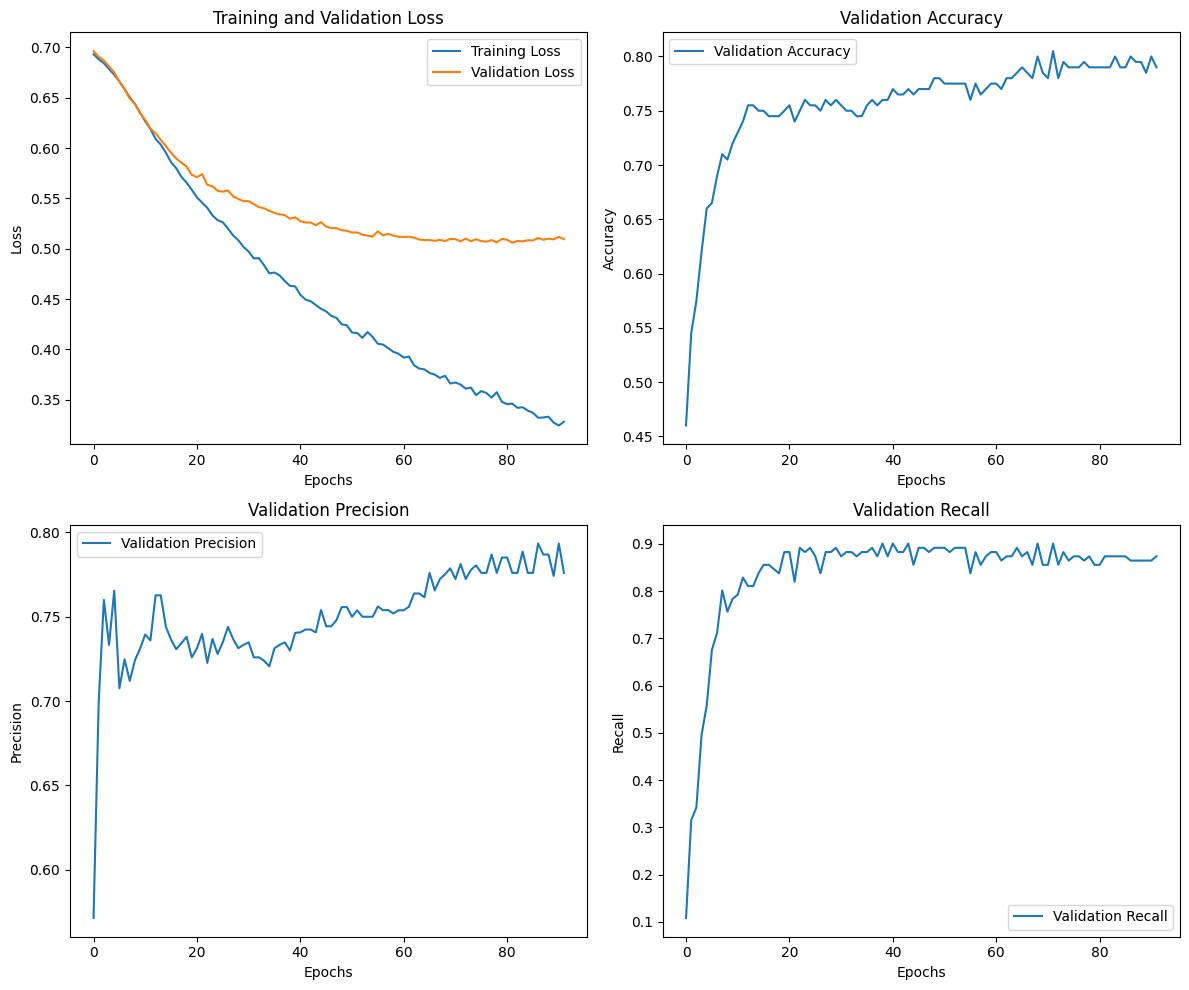

(FeedforwardNN(
   (fc1): Linear(in_features=1024, out_features=16, bias=True)
   (relu): ReLU()
   (fc2): Linear(in_features=16, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 0.79,
 0.776,
 0.8738738738738738)

In [54]:
# Loss and Optimizer
criterion = torch.nn.BCELoss()

def train(model, train_dataloader, val_dataloader, verbose=False, plots=True, n_epochs_stop = 10, lr=0.0001):
    optimizer = torch.optim.Adam(model.parameters(), lr)

    # Lists to store loss and accuracy values
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training Loop
    for epoch in range(200):  # Number of epochs
        model.train()  # Set the model to training mode
        total_loss = 0
        train_steps = 0
        for inputs, targets in train_dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.float())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_steps += 1
        
        avg_train_loss = total_loss / train_steps
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_steps = 0
        correct = 0
        total = 0
        all_targets = []
        all_predictions = []
        with torch.no_grad():
            for inputs, targets in val_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.float())
                val_loss += loss.item()
                val_steps += 1

                predicted = outputs.round().squeeze()  # Assuming a binary classification

                # Accumulate all targets and predictions
                all_targets.extend(targets.tolist())
                all_predictions.extend(predicted.tolist())

                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        # Calculating validation metrics
        avg_val_loss = val_loss / val_steps
        val_losses.append(avg_val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        # Calculate precision and recall
        precision = precision_score(all_targets, all_predictions)
        recall = recall_score(all_targets, all_predictions)
        val_precisions.append(precision)
        val_recalls.append(recall)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == n_epochs_stop:
                print(f'Early stopping at epoch {epoch+1}')
                break

        if verbose:
            print(f'Epoch [{epoch+1}/200], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
                f'Validation Accuracy: {val_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

    # Plotting training and validation loss, accuracy, precision, and recall
    if plots:
        plt.figure(figsize=(12, 10))

        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Validation Accuracy')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(val_precisions, label='Validation Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.title('Validation Precision')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(val_recalls, label='Validation Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.title('Validation Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return model, val_accuracy, precision, recall

train(model, train_dataloader, val_dataloader, verbose=True)

Let's try cross validation to make sure that the validation is not influenced by the validation set sampling.

Can use nouns and noun phrases as complements of the verb 'be'. 
FOLD 0


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 53
FOLD 1
Early stopping at epoch 40
FOLD 2


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 46
FOLD 3
Early stopping at epoch 36
FOLD 4


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 41


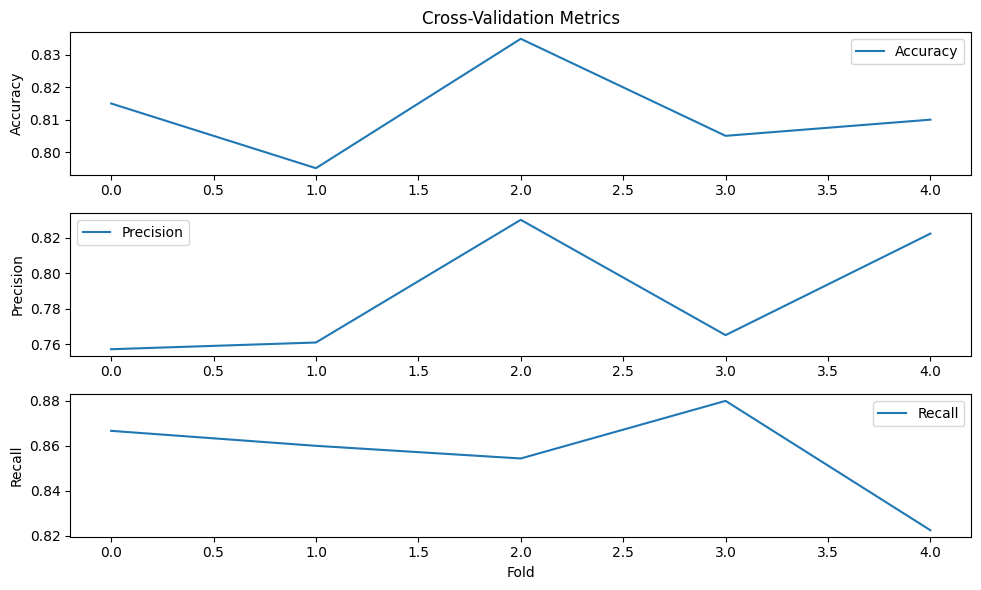

[0.815, 0.795, 0.835, 0.805, 0.81]
Can use prepositional phrases in the front position for focus.
FOLD 0
Early stopping at epoch 21
FOLD 1
Early stopping at epoch 39
FOLD 2


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 12
FOLD 3
Early stopping at epoch 18
FOLD 4
Early stopping at epoch 11


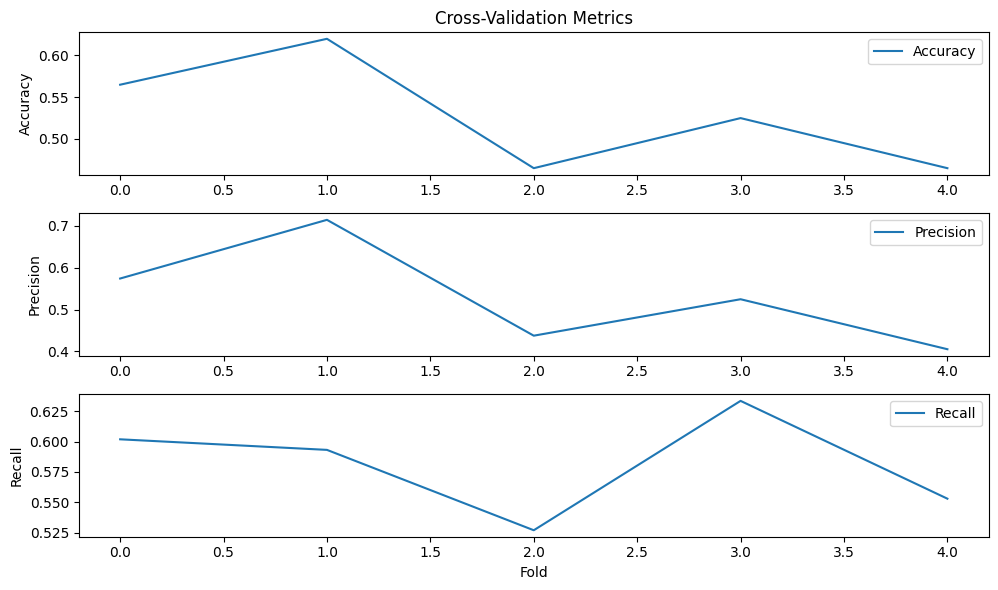

[0.565, 0.62, 0.465, 0.525, 0.465]
Can form conditional subordinate clauses with 'if' + past simple, and would in the main clause, to talk about an imagined situation, often in the context of advice or opinion-giving. 
FOLD 0
Early stopping at epoch 50
FOLD 1
Early stopping at epoch 59
FOLD 2
Early stopping at epoch 32
FOLD 3


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 33
FOLD 4


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 37


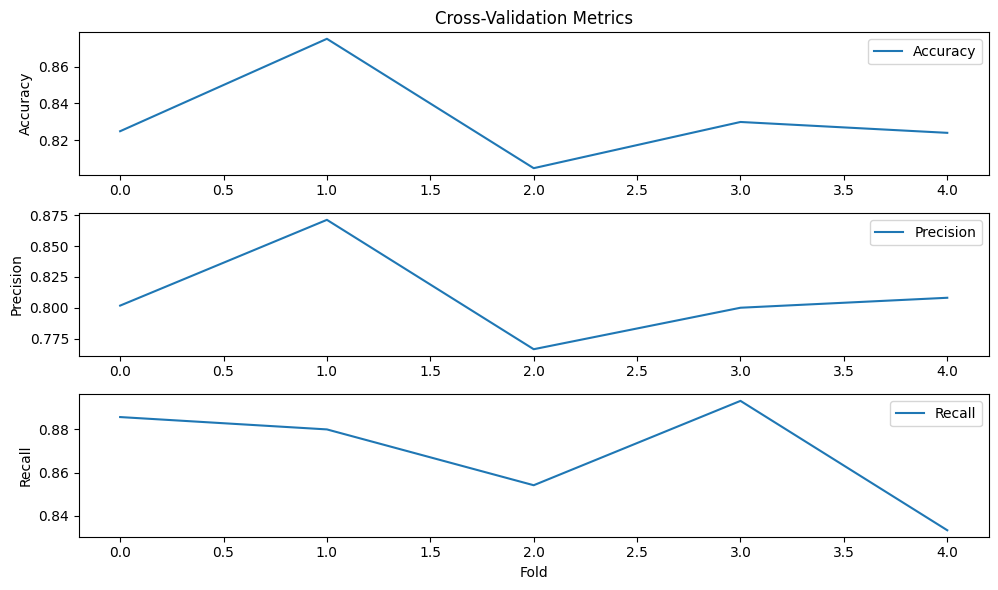

[0.825, 0.875, 0.805, 0.83, 0.8241206030150754]
Can use the past perfect continuous in a relative clause to give background information.  ► relative clauses
FOLD 0
Early stopping at epoch 62
FOLD 1
Early stopping at epoch 52
FOLD 2


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 13
FOLD 3


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dgland

Early stopping at epoch 43
FOLD 4
Early stopping at epoch 18


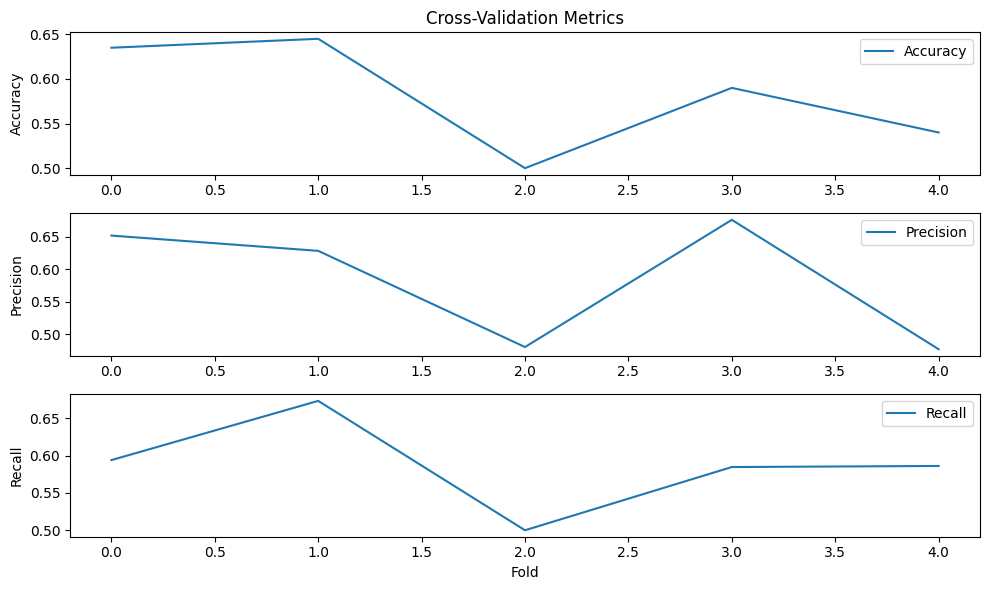

[0.635, 0.645, 0.5, 0.59, 0.54]
Can use 'anything' with post-modifiers to form complex noun phrases as subjects with a singular verb, to give focus. 
FOLD 0
Early stopping at epoch 55
FOLD 1
Early stopping at epoch 28
FOLD 2


/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dglandorf/opt/miniconda3/envs/llm-grammar/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Early stopping at epoch 29
FOLD 3
Early stopping at epoch 56
FOLD 4
Early stopping at epoch 66


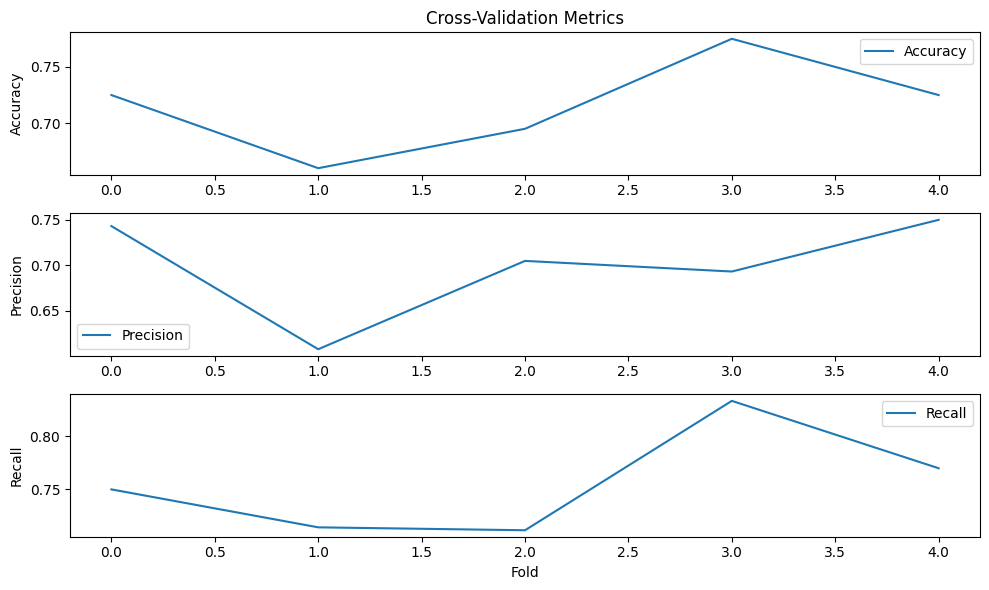

[0.725, 0.66, 0.695, 0.775, 0.725]
Can use an increasing range of adjectives before a noun to express intensity.
FOLD 0
Early stopping at epoch 11
FOLD 1


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.

In [31]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler, DataLoader

k_folds = 5

def CV_train(construction, hidden_dim=16):
    print(construction['Can-do statement'])
    dataset = get_dataset(construction)

    # Lists to store metrics
    accuracies = []
    precisions = []
    recalls = []

    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(list(range(len(dataset))))):
        print(f'FOLD {fold}')

        # Prepare data for fold
        trainloader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_ids))
        testloader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(test_ids))

        # Reinitialize model
        model = FeedforwardNN(input_dim, hidden_dim)

        # Train model
        model, val_accuracy, precision, recall = train(model, trainloader, testloader, plots=False)

        # Store metrics
        accuracies.append(val_accuracy)
        precisions.append(precision)
        recalls.append(recall)

    # Plotting
    plt.figure(figsize=(10, 6))

    plt.subplot(3, 1, 1)
    plt.plot(accuracies, label='Accuracy')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Metrics')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(precisions, label='Precision')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(recalls, label='Recall')
    plt.ylabel('Recall')
    plt.xlabel('Fold')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return accuracies, precisions, recalls

for idx, construction in df.iterrows():
    accuracies, precisions, recalls = CV_train(construction)
    print(accuracies)